
# Quantum Teleportation — Fidelity Analysis (v4)

**Purpose.**
- Auto-detects the hardware bit mapping (Bob, b1, b0).
- Applies correct classical feed‑forward per basis (Z: b0, X: b1, Y: b0 XOR b1).
- Computes per-axis expectations, fidelities, and 95% CIs (bootstrap).
- Produces **all plots** (per-axis checks, bar chart with CIs, ΔF plot, histogram).
- Prints quality‑gate counts and a small ranked table (top/bottom states).

## 0) Imports and environment versions
Brief: load libraries and print versions for reproducibility.

In [2]:

import math, itertools, json, os, sys
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)


Python: 3.12.7
NumPy: 2.3.4
pandas: 2.3.3
matplotlib: 3.10.6


## 1) Load simulator and hardware measurements
Brief: load JSON files built by the builder; normalize into parallel dicts for simulator and hardware.

In [3]:

# Expected files placed by the builder (adjust paths if needed)
SIM_PATH = "teleportation_measurements.json"
HW_PATH  = "teleportation_measurements_hardware.json"

def _as_np(x):
    try:
        return float(x)
    except Exception:
        return x

def load_measurements(path: str):
    with open(path, "r") as f:
        obj = json.load(f)
    theta = {int(k): float(v) for k, v in obj.get("theta", {}).items()}
    phi   = {int(k): float(v) for k, v in obj.get("phi", {}).items()}
    axis  = {int(k): str(v)   for k, v in obj.get("axis", {}).items()}
    shots = {int(k): int(v)   for k, v in obj.get("shots", {}).items()}
    counts= {int(k): {str(b): int(c) for b, c in v.items()} for k, v in obj.get("counts", {}).items()}
    return theta, phi, axis, shots, counts, obj

theta_sim, phi_sim, axis_sim, shots_sim, counts_sim, SIM_RAW = load_measurements(SIM_PATH)
theta_hw,  phi_hw,  axis_hw,  shots_hw,  counts_hw,  HW_RAW  = load_measurements(HW_PATH)

idxs = sorted(list(set(theta_sim.keys()) & set(phi_sim.keys()) & set(axis_sim.keys())))
print("Loaded indices:", len(idxs))
print("Example SIM keys:", list(next(iter(counts_sim.values())).keys())[:6])
print("Example HW  keys:", list(next(iter(counts_hw.values())).keys())[:6])


Loaded indices: 48
Example SIM keys: ['1 11', '0 01', '1 10', '0 00']
Example HW  keys: ['000', '001', '111', '110', '010', '101']


## 2) Core helpers (target Bloch vector, parsing, corrections)
Brief: single source of truth for parsing keys and applying virtual corrections.

In [4]:

def target_bloch(theta, phi):
    return np.array([math.sin(theta)*math.cos(phi),
                     math.sin(theta)*math.sin(phi),
                     math.cos(theta)], dtype=float)

def flip_for_basis(b0, b1, axis):
    if axis == "Z": return b0
    if axis == "X": return b1
    if axis == "Y": return b0 ^ b1
    raise ValueError(axis)

def parse_key_sim(k: str):
    # format is "b ab" but ab is actually b0 then b1
    parts = k.strip().split()
    if len(parts) != 2:
        raise ValueError(f"Unexpected SIM key format: {k!r}")
    b  = int(parts[0])
    ab = parts[1]
    if len(ab) != 2:
        raise ValueError(f"Unexpected ab pair in SIM key: {k!r}")
    b0 = int(ab[0]); b1 = int(ab[1])   # NOTE: swapped order
    return b, b1, b0                   # return in (b, b1, b0) order

def parse_key_hw(k: str, mapping: Dict[str,int]):
    s = k.replace(" ", "")
    b  = int(s[mapping['bob']])
    b1 = int(s[mapping['b1']])
    b0 = int(s[mapping['b0']])
    return b, b1, b0

def corrected_counts_sim(counts: dict, axis: str) -> dict:
    out = {"0": 0, "1": 0}
    for k, c in counts.items():
        b, b1, b0 = parse_key_sim(k)
        beff = b ^ flip_for_basis(b0, b1, axis)
        out[str(beff)] += int(c)
    return out

def corrected_counts_hw(counts: dict, axis: str, mapping: Dict[str,int]) -> dict:
    out = {"0": 0, "1": 0}
    for k, c in counts.items():
        b, b1, b0 = parse_key_hw(k, mapping)
        beff = b ^ flip_for_basis(b0, b1, axis)
        out[str(beff)] += int(c)
    return out

def exp_from_corrected_counts(cc: dict) -> float:
    n0 = int(cc.get("0", 0)); n1 = int(cc.get("1", 0)); tot = n0 + n1
    return 0.0 if tot == 0 else (n0/tot - n1/tot)


## 3) Build (theta, phi) groups and keep complete X/Y/Z triplets
Brief: we need one X, one Y, and one Z measurement per target state to form Bloch vectors.

In [5]:

def group_by_angles(theta_dict, phi_dict, axis_dict):
    groups = defaultdict(dict)
    for i in theta_dict.keys():
        groups[(theta_dict[i], phi_dict[i])][axis_dict[i]] = i
    return {k:v for k,v in groups.items() if set(v)=={"X","Y","Z"}}

complete_groups = group_by_angles(theta_sim, phi_sim, axis_sim)
print("Complete (X,Y/Z) groups:", len(complete_groups))
assert len(complete_groups) > 0, "No complete groups found."


Complete (X,Y/Z) groups: 16


## 4) Auto-detect hardware bit mapping
Brief: try all 6 permutations of positions {0,1,2} for {bob,b1,b0}, choose the one maximizing corr(ideal, measured) over all states & axes.

In [6]:

print("HW example keys:", list(next(iter(counts_hw.values())).keys())[:6])

def mapping_score(mapping):
    ideals, meas = [], []
    for (th, ph), idx_map in complete_groups.items():
        r_tgt = target_bloch(th, ph)
        for j, axis in enumerate(["X","Y","Z"]):
            idx = idx_map[axis]
            cc  = corrected_counts_hw(counts_hw[idx], axis, mapping)
            ideals.append(r_tgt[j])
            meas.append(exp_from_corrected_counts(cc))
    ideals = np.array(ideals, float); meas = np.array(meas, float)
    if np.std(meas) < 1e-9 or np.std(ideals) < 1e-9:
        return -np.inf
    return np.corrcoef(ideals, meas)[0,1]

best = None
for perm in itertools.permutations([0,1,2]):
    cand = {'bob': perm[0], 'b1': perm[1], 'b0': perm[2]}
    sc   = mapping_score(cand)
    print("Mapping test", cand, "score:", round(sc, 3))
    if best is None or sc > best[1]:
        best = (cand, sc)

mapping = best[0]
print("\\nChosen mapping:", mapping, "corr=", round(best[1], 3))


HW example keys: ['000', '001', '111', '110', '010', '101']
Mapping test {'bob': 0, 'b1': 1, 'b0': 2} score: 0.443
Mapping test {'bob': 0, 'b1': 2, 'b0': 1} score: 0.997
Mapping test {'bob': 1, 'b1': 0, 'b0': 2} score: 0.441
Mapping test {'bob': 1, 'b1': 2, 'b0': 0} score: 0.912
Mapping test {'bob': 2, 'b1': 0, 'b0': 1} score: 0.612
Mapping test {'bob': 2, 'b1': 1, 'b0': 0} score: 0.465
\nChosen mapping: {'bob': 0, 'b1': 2, 'b0': 1} corr= 0.997


## 5) Per-axis expectation check (after correction)
Brief: compare measured X, Y, Z vs ideal values across target states; points should lie near the diagonal if corrections and mapping are right.

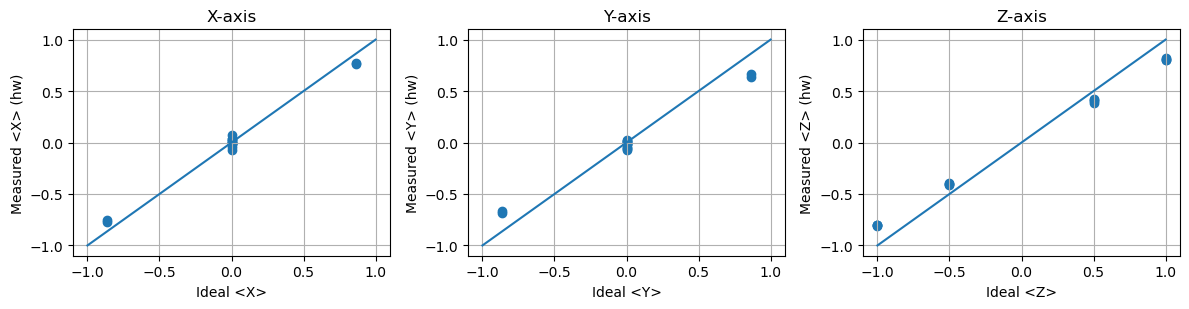

In [7]:

meas = {"X":[], "Y":[], "Z":[]}; ideal= {"X":[], "Y":[], "Z":[]}
for (th, ph), idx_map in sorted(complete_groups.items()):
    r_tgt = target_bloch(th, ph)
    for j, axis in enumerate(["X","Y","Z"]):
        idx = idx_map[axis]
        cc  = corrected_counts_hw(counts_hw[idx], axis, mapping)
        E   = exp_from_corrected_counts(cc)
        meas[axis].append(E); ideal[axis].append(r_tgt[j])

plt.figure(figsize=(12,3.2))
for k, axname in enumerate(["X","Y","Z"]):
    plt.subplot(1,3,k+1)
    plt.scatter(ideal[axname], meas[axname])
    plt.plot([-1,1], [-1,1])
    plt.xlabel(f"Ideal <{axname}>"); plt.ylabel(f"Measured <{axname}> (hw)")
    plt.title(f"{axname}-axis"); plt.grid(True)
plt.tight_layout()
plt.savefig("axis_correlation_hw.png", dpi=300, bbox_inches="tight")
plt.show()


## 6) Bootstrap per‑state fidelity with 95% CI
Brief: resample counts with replacement (multinomial), apply corrections, form Bloch vector, compute F = (1 + r_out·r_target)/2.

In [10]:

def bootstrap_fidelity_for_state(idx_map, th, ph, is_sim, B=1500, seed=42, mapping=None):
    rng = np.random.default_rng(seed)
    r_tar = target_bloch(th, ph)
    Fs = []
    for _ in range(B):
        exps = {}
        for axis in ["X","Y","Z"]:
            raw = counts_sim[idx_map[axis]] if is_sim else counts_hw[idx_map[axis]]
            keys = list(raw.keys())
            vals = np.array([raw[k] for k in keys], dtype=int)
            tot  = int(vals.sum())
            if tot == 0:
                exps[axis] = 0.0
                continue
            p = vals / tot
            sample = rng.multinomial(tot, p)
            sample_counts = {k: int(v) for k, v in zip(keys, sample)}
            if is_sim:
                cc = corrected_counts_sim(sample_counts, axis)
            else:
                if mapping is None:
                    raise ValueError("mapping required for hardware bootstrap")
                cc = corrected_counts_hw(sample_counts, axis, mapping)
            exps[axis] = exp_from_corrected_counts(cc)
        r = np.array([exps["X"], exps["Y"], exps["Z"]], dtype=float)
        Fs.append((1 + float(r @ r_tar))/2)
    Fs = np.array(Fs, dtype=float)
    return Fs.mean(), np.percentile(Fs, [2.5, 97.5])

rows_ci = []
for (th, ph), idx_map in sorted(complete_groups.items()):
    Fm_sim, (lo_sim, hi_sim) = bootstrap_fidelity_for_state(idx_map, th, ph, True, 1500, 42)
    Fm_hw,  (lo_hw,  hi_hw)  = bootstrap_fidelity_for_state(idx_map, th, ph, False,1500, 43, mapping=mapping)
    rows_ci.append({"theta": th, "phi": ph,
                    "F_sim": Fm_sim, "F_sim_lo95": lo_sim, "F_sim_hi95": hi_sim,
                    "F_hw":  Fm_hw,  "F_hw_lo95":  lo_hw,  "F_hw_hi95":  hi_hw})
dfCI = pd.DataFrame(rows_ci).sort_values(["theta","phi"]).reset_index(drop=True)
dfCI.head()


,theta,phi,F_sim,F_sim_lo95,F_sim_hi95,F_hw,F_hw_lo95,F_hw_hi95
0,0.000000,0.000000,1.00000,1.000000,1.000000,0.911029,0.902500,0.919750
1,0.000000,1.570796,1.00000,1.000000,1.000000,0.898548,0.889619,0.907750
2,0.000000,3.141593,1.00000,1.000000,1.000000,0.900061,0.890500,0.909250
3,0.000000,4.712389,1.00000,1.000000,1.000000,0.905587,0.896750,0.914631
4,1.047198,0.000000,1.00124,0.991442,1.010215,0.935632,0.924392,0.946515


## 7) Bar chart with 95% CI (sim vs hw) + classical limit line
Brief: side‑by‑side bars per state; dashed line at 2/3 shows classical threshold.

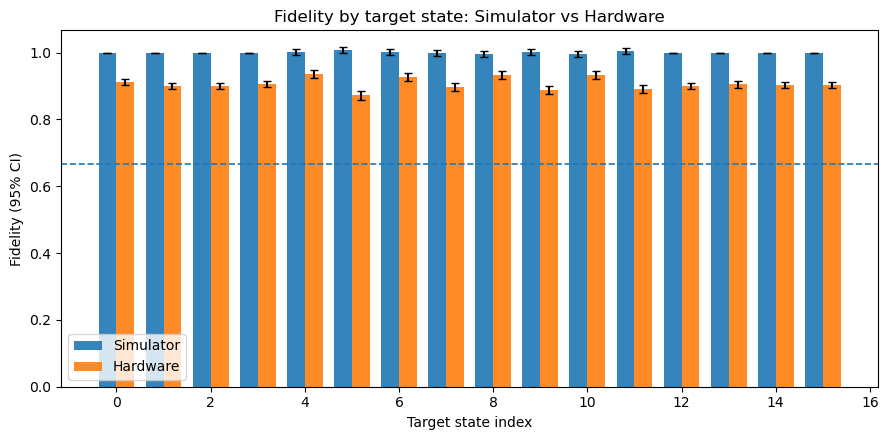

In [11]:

two_thirds = 2/3

plt.figure(figsize=(9,4.5))
x = np.arange(len(dfCI))
w = 0.38

plt.bar(x-w/2, dfCI["F_sim"], yerr=[dfCI["F_sim"]-dfCI["F_sim_lo95"], dfCI["F_sim_hi95"]-dfCI["F_sim"]],
        width=w, capsize=3, label="Simulator", alpha=0.9)
plt.bar(x+w/2, dfCI["F_hw"],  yerr=[dfCI["F_hw"]-dfCI["F_hw_lo95"],   dfCI["F_hw_hi95"]-dfCI["F_hw"]],
        width=w, capsize=3, label="Hardware",  alpha=0.9)

plt.axhline(two_thirds, linestyle="--", linewidth=1.2)
plt.xlabel("Target state index"); plt.ylabel("Fidelity (95% CI)")
plt.title("Fidelity by target state: Simulator vs Hardware")
plt.legend(); plt.tight_layout(); plt.savefig("fidelity_sim_v_hard.png", dpi=300, bbox_inches="tight"); plt.show()


## 8) Delta fidelity plot (sorted)
Brief: visualize where hardware deviates from simulator: ΔF = F_hw − F_sim with 95% CI error bars.

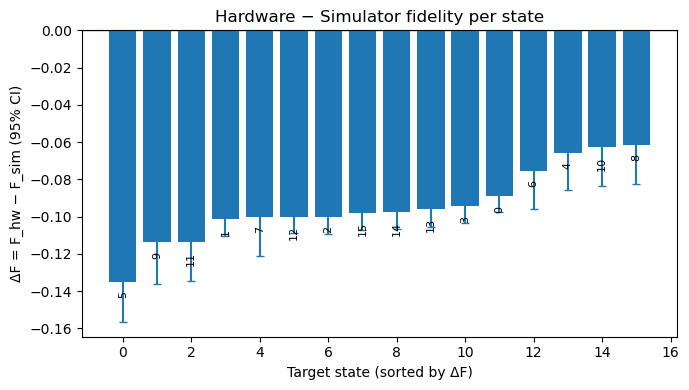

In [15]:

import numpy as np
import matplotlib.pyplot as plt

# Build ΔF and keep a state_id column
df_delta = dfCI.copy()
df_delta["state_id"] = df_delta.index  # original index = state label

df_delta["dF"]    = df_delta["F_hw"]      - df_delta["F_sim"]
df_delta["dF_lo"] = df_delta["F_hw_lo95"] - df_delta["F_sim_hi95"]
df_delta["dF_hi"] = df_delta["F_hw_hi95"] - df_delta["F_sim_lo95"]

# Sort by ΔF (most negative to least negative)
df_delta = df_delta.sort_values("dF").reset_index(drop=True)

x = np.arange(len(df_delta))

fig, ax = plt.subplots(figsize=(7, 4))

# Bars for ΔF
bars = ax.bar(x, df_delta["dF"])

# Asymmetric error bars (95% CI)
yerr_lower = df_delta["dF"] - df_delta["dF_lo"]
yerr_upper = df_delta["dF_hi"] - df_delta["dF"]
ax.errorbar(
    x,
    df_delta["dF"],
    yerr=[yerr_lower, yerr_upper],
    fmt="none",
    capsize=3,
)

ax.axhline(0.0, linewidth=1.0)

ax.set_xlabel("Target state (sorted by ΔF)")
ax.set_ylabel("ΔF = F_hw − F_sim (95% CI)")
ax.set_title("Hardware − Simulator fidelity per state")

# --- Add labels: original state index on each bar ---
for xpos, y, sid in zip(x, df_delta["dF"], df_delta["state_id"]):
    ax.text(
        xpos,
        y - 0.005,     # small offset; bars are negative
        str(sid),
        ha="center",
        va="top",
        fontsize=8,
        rotation=90,
    )

plt.tight_layout()
plt.savefig("hardsim_fidelity_per_state.png", dpi=300, bbox_inches="tight"); plt.show()


## Bloch Sphere for fidelity (Matplotlib)

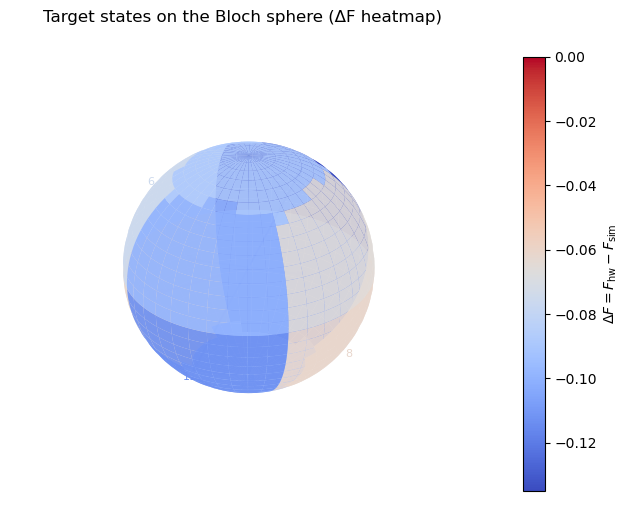

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- Prepare Bloch coordinates and metric ----------
bloch_coords = np.array([
    target_bloch(th, ph) for th, ph in zip(dfCI["theta"], dfCI["phi"])
])  # shape (N, 3), should already be unit vectors
rx = bloch_coords[:, 0]
ry = bloch_coords[:, 1]
rz = bloch_coords[:, 2]

state_ids = dfCI.index.to_numpy()

# Metric to color by: ΔF or F_hw
metric = (dfCI["F_hw"] - dfCI["F_sim"]).to_numpy()   # ΔF
metric_label = r"$\Delta F = F_{\mathrm{hw}} - F_{\mathrm{sim}}$"
# If you want raw hardware fidelity instead:
# metric = dfCI["F_hw"].to_numpy()
# metric_label = r"Hardware fidelity $F_{\mathrm{hw}}$"

# Use a diverging colormap and center the scale at 0
vmin = metric.min()
vmax = 0.0  # since ΔF ≤ 0, best case is 0
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.coolwarm  # or viridis if you prefer
colors_vec = cmap(norm(metric))

# ---------- Create figure & axes ----------
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111, projection="3d")

# ---------- Sphere grid ----------
u = np.linspace(0, 2*np.pi, 120)
v = np.linspace(0, np.pi, 60)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

# Flatten sphere points for nearest-neighbor mapping
sphere_points = np.stack([xs.ravel(), ys.ravel(), zs.ravel()], axis=1)  # (P, 3)

# Compute cosine of angle between each sphere point and each target Bloch vector
# (since both are unit, dot product = cos(angle))
dots = sphere_points @ bloch_coords.T  # (P, N)
nearest_idx = np.argmax(dots, axis=1)  # index of nearest target state
sphere_metric = metric[nearest_idx].reshape(xs.shape)

# Map metric to colors on the sphere surface
sphere_colors = cmap(norm(sphere_metric))

# ---------- Draw Bloch sphere as heatmap ----------
ax.plot_surface(
    xs, ys, zs,
    facecolors=sphere_colors,
    edgecolor="none",
    linewidth=0.0,
    antialiased=True,
    shade=False,
    alpha=0.9,
)

# ---------- Vectors for each target state ----------
for x, y, z, c, sid in zip(rx, ry, rz, colors_vec, state_ids):
    ax.quiver(
        0, 0, 0,
        x, y, z,
        arrow_length_ratio=0.08,
        linewidth=1.4,
        color=c,
    )
    ax.text(
        1.05 * x, 1.05 * y, 1.05 * z,
        str(sid),
        fontsize=8,
        ha="center",
        va="center",
        color=c,
    )

# ---------- Cosmetics ----------
ax.set_box_aspect((1, 1, 1))
lim = 1.1
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_zlim([-lim, lim])

# Hide outer axes / ticks so sphere floats
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

ax.set_title("Target states on the Bloch sphere (ΔF heatmap)", pad=14)

# ---------- Colorbar ----------
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(metric)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.08)
cbar.set_label(metric_label)

plt.tight_layout()
plt.savefig("bloch_sphere_deltaF_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


## Bloch Sphere (Qutip)

In [19]:
!pip install qutip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ------- -------------------------------- 2.1/10.7 MB 19.5 MB/s eta 0:00:01
   ------------------------------- -------- 8.4/10.7 MB 27.4 MB/s eta 0:00:01
   ------------------------------------ --- 9.7/10.7 MB 23.2 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 15.5 MB/s  0:00:00


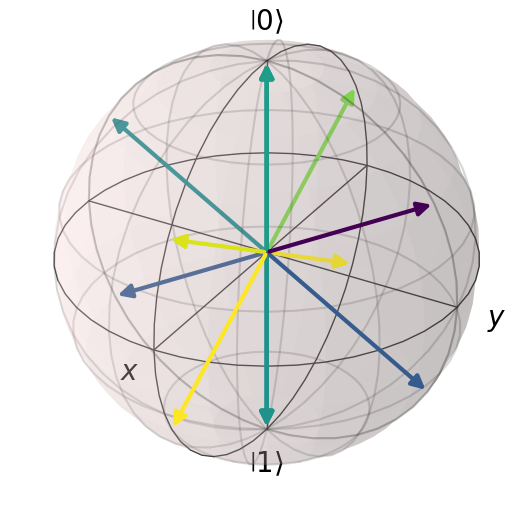

In [22]:
from qutip import Bloch
import numpy as np
import matplotlib.pyplot as plt

bloch_coords = np.array([
    target_bloch(th, ph) for th, ph in zip(dfCI["theta"], dfCI["phi"])
])
state_ids = dfCI.index.to_numpy()

# metric: choose what you want to color by
metric = (dfCI["F_hw"] - dfCI["F_sim"]).to_numpy()
vmin, vmax = metric.min(), metric.max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
colors = [cmap(norm(m)) for m in metric]

b = Bloch()
b.vector_width = 3
b.frame_alpha = 0.2
b.frame_color = [0.2, 0.2, 0.2]

# Add vectors, one per state, colored by metric
for (x, y, z), col in zip(bloch_coords, colors):
    b.add_vectors([x, y, z])
    # After add_vectors, b.vector_color is a list; update the last entry
    if b.vector_color is None:
        b.vector_color = [col]
    else:
        # ensure list long enough
        while len(b.vector_color) < len(b.vectors):
            b.vector_color.append(col)
        b.vector_color[-1] = col

b.show()


## Bloch Sphere (Plotly)

In [25]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ------------ --------------------------- 3.1/9.9 MB 15.3 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.9 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 16.7 MB/s  0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ------------------------------------

In [26]:
import numpy as np
import plotly.graph_objects as go

# ---------- Bloch vectors and metric ----------
bloch_coords = np.array([
    target_bloch(th, ph) for th, ph in zip(dfCI["theta"], dfCI["phi"])
])  # (N,3)
rx, ry, rz = bloch_coords.T
state_ids = dfCI.index.to_numpy()

# Metric: ΔF or F_hw
metric = (dfCI["F_hw"] - dfCI["F_sim"]).to_numpy()   # ΔF
metric_label = "ΔF = F_hw − F_sim"
# Or:
# metric = dfCI["F_hw"].to_numpy()
# metric_label = "Hardware fidelity F_hw"

# Color scale centered at 0 (for ΔF)
vmin = metric.min()
vmax = 0.0
colorscale = "RdBu"   # diverging; change if you like

# ---------- Sphere grid ----------
u = np.linspace(0, 2*np.pi, 120)
v = np.linspace(0, np.pi, 60)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

sphere_points = np.stack([xs.ravel(), ys.ravel(), zs.ravel()], axis=1)  # (P,3)

# Nearest target state for each sphere point (Voronoi-ish heatmap)
dots = sphere_points @ bloch_coords.T        # dot products = cos(angle)
nearest_idx = np.argmax(dots, axis=1)
sphere_metric = metric[nearest_idx].reshape(xs.shape)

# ---------- Build Plotly figure ----------
fig = go.Figure()

# Surface heatmap
fig.add_surface(
    x=xs,
    y=ys,
    z=zs,
    surfacecolor=sphere_metric,
    colorscale=colorscale,
    cmin=vmin,
    cmax=vmax,
    showscale=True,
    opacity=0.9,
    colorbar=dict(title=metric_label),
)

# Bloch vectors as lines + text
for (x, y, z, m, sid) in zip(rx, ry, rz, metric, state_ids):
    fig.add_trace(go.Scatter3d(
        x=[0, x],
        y=[0, y],
        z=[0, z],
        mode="lines+text",
        text=[None, str(sid)],
        textposition="top center",
        line=dict(width=6, color=m),
        # color via colorscale
        marker=dict(size=1, color=m, colorscale=colorscale, cmin=vmin, cmax=vmax),
        showlegend=False,
        hovertemplate=f"state {sid}<br>ΔF={m:.3f}<extra></extra>",
    ))

fig.update_layout(
    title="Target states on the Bloch sphere (ΔF heatmap)",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data",
    ),
    margin=dict(l=0, r=0, t=40, b=0),
)

# Save as interactive HTML
fig.write_html("bloch_sphere_interactive.html", include_plotlyjs="cdn")
fig.show()


## Bloch Animation

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.animation import FuncAnimation, PillowWriter

# ---------- Prepare Bloch coordinates and metric ----------
bloch_coords = np.array([
    target_bloch(th, ph) for th, ph in zip(dfCI["theta"], dfCI["phi"])
])
rx, ry, rz = bloch_coords.T
state_ids = dfCI.index.to_numpy()

# Metric: ΔF
metric = (dfCI["F_hw"] - dfCI["F_sim"]).to_numpy()
metric_label = r"$\Delta F = F_{\mathrm{hw}} - F_{\mathrm{sim}}$"

# Color scale centered at 0
vmin = metric.min()
vmax = 0.0
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.coolwarm
colors_vec = cmap(norm(metric))

# ---------- Figure / axes ----------
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111, projection="3d")

# ---------- Sphere grid and heatmap ----------
u = np.linspace(0, 2*np.pi, 120)
v = np.linspace(0, np.pi, 60)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

sphere_points = np.stack([xs.ravel(), ys.ravel(), zs.ravel()], axis=1)
dots = sphere_points @ bloch_coords.T
nearest_idx = np.argmax(dots, axis=1)
sphere_metric = metric[nearest_idx].reshape(xs.shape)
sphere_colors = cmap(norm(sphere_metric))

surf = ax.plot_surface(
    xs, ys, zs,
    facecolors=sphere_colors,
    edgecolor="none",
    linewidth=0.0,
    antialiased=True,
    shade=False,
    alpha=0.9,
)

# ---------- Add Bloch axes + labels ----------
ax.plot([-1, 1], [0, 0], [0, 0], color="black", linewidth=1.2)  # X-axis
ax.plot([0, 0], [-1, 1], [0, 0], color="black", linewidth=1.2)  # Y-axis
ax.plot([0, 0], [0, 0], [-1, 1], color="black", linewidth=1.2)  # Z-axis

# labels at the ends of the axes
ax.text(1.2,  0.0,  0.0, "X", fontsize=10, ha="center", va="center")
ax.text(0.0,  1.2,  0.0, "Y", fontsize=10, ha="center", va="center")
ax.text(0.0,  0.0,  1.2, "Z", fontsize=10, ha="center", va="center")

# ---------- Vectors, cosmetics, colorbar, etc. as before ----------
lim = 1.25  # slightly larger to give room for labels
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_zlim([-lim, lim])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

# ---------- Vectors ----------
for x, y, z, c, sid in zip(rx, ry, rz, colors_vec, state_ids):
    ax.quiver(
        0, 0, 0,
        x, y, z,
        arrow_length_ratio=0.08,
        linewidth=1.4,
        color=c,
    )
    ax.text(
        1.05 * x, 1.05 * y, 1.05 * z,
        str(sid),
        fontsize=8,
        ha="center",
        va="center",
        color=c,
    )

# ---------- Cosmetics ----------
ax.set_box_aspect((1, 1, 1))
lim = 1.1
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_zlim([-lim, lim])

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

ax.set_title("Target states on the Bloch sphere (ΔF heatmap)", pad=14)

# Colorbar (static)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(metric)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.08)
cbar.set_label(metric_label)

def update(frame):
    # frame will be an angle in degrees
    ax.view_init(elev=20, azim=frame)
    return (fig,)

# 0→360 degrees, 180 frames (tweak step size for slower/faster spin)
frames = np.linspace(0, 360, 180)

anim = FuncAnimation(
    fig,
    update,
    frames=frames,
    interval=50,   # ms between frames (~20 fps)
    blit=False,
)

writer = PillowWriter(fps=20)
anim.save("bloch_sphere_spin.gif", writer=writer, dpi=150)
plt.close(fig)


In [30]:
num_states = len(dfCI)                 # how many target states
num_regions = len(np.unique(nearest_idx))
print("states:", num_states, "   Voronoi regions on grid:", num_regions)


states: 16    Voronoi regions on grid: 13


## 9) Fidelity distribution histogram
Brief: show the spread for simulator vs hardware; add a vertical 2/3 reference line.

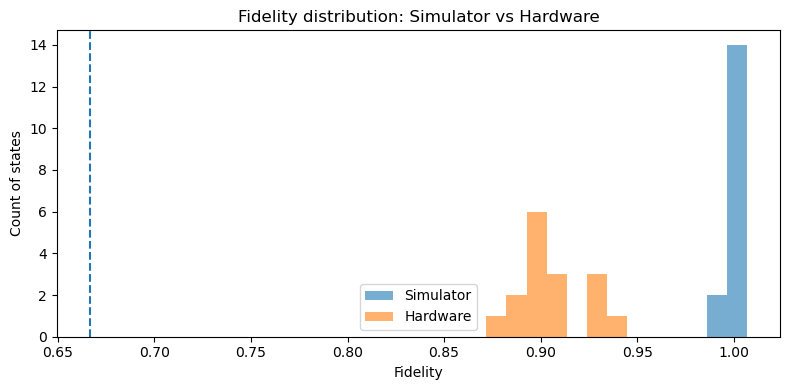

In [13]:

plt.figure(figsize=(8,4))
bins = np.linspace(min(dfCI["F_sim"].min(), dfCI["F_hw"].min())-1e-6,
                   max(dfCI["F_sim"].max(), dfCI["F_hw"].max())+1e-6, 14)
plt.hist(dfCI["F_sim"], bins=bins, alpha=0.6, label="Simulator")
plt.hist(dfCI["F_hw"],  bins=bins, alpha=0.6, label="Hardware")
plt.axvline(2/3, linestyle="--")
plt.xlabel("Fidelity"); plt.ylabel("Count of states")
plt.title("Fidelity distribution: Simulator vs Hardware")
plt.legend(); plt.tight_layout(); plt.savefig("fidelity_distribution.png", dpi=300, bbox_inches="tight"); plt.show()


## 10) Quality gate and KPIs
Brief: headline metrics for slides—mean fidelities with 95% CI and counts above 2/3.

In [22]:

def nested_bootstrap_mean_F(complete_groups, B=300, seed=777, is_sim=True, mapping=None):
    rng = np.random.default_rng(seed)
    groups_list = list(sorted(complete_groups.items()))
    means = []
    for _ in range(B):
        Fs = []
        pick = rng.integers(0, len(groups_list), size=len(groups_list))
        for j in pick:
            (th, ph), idx_map = groups_list[j]
            Fm, _ = bootstrap_fidelity_for_state(idx_map, th, ph, is_sim, 200, int(rng.integers(0, 1e9)), mapping=mapping)
            Fs.append(Fm)
        means.append(np.mean(Fs))
    means = np.array(means, float)
    return means.mean(), np.percentile(means, [2.5, 97.5])

mean_sim, (mean_sim_lo, mean_sim_hi) = nested_bootstrap_mean_F(complete_groups, is_sim=True)
mean_hw,  (mean_hw_lo,  mean_hw_hi)  = nested_bootstrap_mean_F(complete_groups, is_sim=False, mapping=mapping)

gate_point  = int((dfCI["F_hw"] > 2/3).sum())
gate_strict = int((dfCI["F_hw_lo95"] > 2/3).sum())

kpi = pd.DataFrame({
    "Metric": ["Mean fidelity (sim)", "Mean fidelity (hw)", "States > 2/3 (point)", "States > 2/3 (CI strict)"],
    "Value":  [f"{mean_sim:.3f} [95% CI {mean_sim_lo:.3f}, {mean_sim_hi:.3f}]",
               f"{mean_hw:.3f} [95% CI {mean_hw_lo:.3f}, {mean_hw_hi:.3f}]",
               f"{gate_point} / {len(dfCI)}",
               f"{gate_strict} / {len(dfCI)}"]
})
kpi


,Metric,Value
0,Mean fidelity (sim),"1.000 [95% CI 0.999, 1.002]"
1,Mean fidelity (hw),"0.907 [95% CI 0.898, 0.916]"
2,States > 2/3 (point),16 / 16
3,States > 2/3 (CI strict),16 / 16


## 11) Top‑5 and Bottom‑5 states by hardware fidelity
Brief: quick table for Q&A; add angles for easy reproduction.

In [23]:

df_rank = dfCI.copy()
df_rank = df_rank.sort_values("F_hw", ascending=False).reset_index(drop=True)
top5    = df_rank.head(5).copy()
bottom5 = df_rank.tail(5).copy()

from IPython.display import display
display(pd.concat({"Top-5": top5[["theta","phi","F_hw","F_hw_lo95","F_hw_hi95"]],
                   "Bottom-5": bottom5[["theta","phi","F_hw","F_hw_lo95","F_hw_hi95"]]},
                  axis=1))


Top-5                                          Bottom-5            \
       theta       phi      F_hw F_hw_lo95 F_hw_hi95     theta       phi   
0   1.047198  0.000000  0.935632  0.924392  0.946515       NaN       NaN   
1   2.094395  0.000000  0.933178  0.921415  0.944126       NaN       NaN   
2   2.094395  3.141593  0.932636  0.921004  0.943983       NaN       NaN   
3   1.047198  3.141593  0.927427  0.916095  0.938062       NaN       NaN   
4   0.000000  0.000000  0.911029  0.902500  0.919750       NaN       NaN   
11       NaN       NaN       NaN       NaN       NaN  0.000000  1.570796   
12       NaN       NaN       NaN       NaN       NaN  1.047198  4.712389   
13       NaN       NaN       NaN       NaN       NaN  2.094395  4.712389   
14       NaN       NaN       NaN       NaN       NaN  2.094395  1.570796   
15       NaN       NaN       NaN       NaN       NaN  1.047198  1.570796   

                                  
        F_hw F_hw_lo95 F_hw_hi95  
0        NaN       NaN       NaN  
1        NaN       NaN       NaN  
2        NaN       NaN       NaN  
3        NaN       NaN       NaN  
4        NaN       NaN       NaN  
11  0.898548  0.889619  0.907750  
12  0.897680  0.885481  0.910108  
13  0.891110  0.879112  0.903599  
14  0.887767  0.875444  0.901002  
15  0.871906  0.859054  0.884342

## Checks

In [13]:
# 1) No-correction SIM: ignore Alice bits; just compute E[b] per axis
def exp_sim_no_correction(counts_sim_axis):
    n0 = int(counts_sim_axis.get("0 00", 0) + counts_sim_axis.get("0 01", 0) +
             counts_sim_axis.get("0 10", 0) + counts_sim_axis.get("0 11", 0))
    n1 = int(counts_sim_axis.get("1 00", 0) + counts_sim_axis.get("1 01", 0) +
             counts_sim_axis.get("1 10", 0) + counts_sim_axis.get("1 11", 0))
    tot = n0 + n1
    return 0.0 if tot == 0 else (n0/tot - n1/tot)

def sim_exp_vector_no_corr(idx_map):
    return {
        ax: exp_sim_no_correction(counts_sim[idx_map[ax]])
        for ax in ["X","Y","Z"]
    }

# 2) “Normal” SIM correction (what you’re doing now)
def sim_exp_vector_with_corr(idx_map):
    out = {}
    for ax in ["X","Y","Z"]:
        cc = corrected_counts_sim(counts_sim[idx_map[ax]], ax)  # uses b0/b1 flips
        out[ax] = exp_from_corrected_counts(cc)
    return out

# 3) SIM correction with b1/b0 swapped (just to rule it out)
def corrected_counts_sim_swap(counts, axis):
    out = {"0":0,"1":0}
    for k,c in counts.items():
        b, b1, b0 = parse_key_sim(k)  # your current parser
        # swap:
        b1, b0 = b0, b1
        flip = b0 if axis=="Z" else (b1 if axis=="X" else (b0 ^ b1))
        out[str(b ^ flip)] += int(c)
    return out

def sim_exp_vector_with_corr_swapped(idx_map):
    out = {}
    for ax in ["X","Y","Z"]:
        cc = corrected_counts_sim_swap(counts_sim[idx_map[ax]], ax)
        out[ax] = exp_from_corrected_counts(cc)
    return out

# Correlation test vs ideal for each option
import numpy as np, math

def corr_for(method):
    ideals, meas = [], []
    for (th, ph), idx_map in sorted(complete_groups.items()):
        rx, ry, rz = target_bloch(th, ph)
        ideals += [rx, ry, rz]
        v = method(idx_map)
        meas   += [v["X"], v["Y"], v["Z"]]
    ideals = np.array(ideals, float); meas = np.array(meas, float)
    return np.corrcoef(ideals, meas)[0,1]

print("SIM corr (no-correction):      ", round(corr_for(sim_exp_vector_no_corr), 3))
print("SIM corr (with-correction):    ", round(corr_for(sim_exp_vector_with_corr), 3))
print("SIM corr (swap b1/b0 + corr):  ", round(corr_for(sim_exp_vector_with_corr_swapped), 3))


SIM corr (no-correction):       -0.201
SIM corr (with-correction):     0.428
SIM corr (swap b1/b0 + corr):   1.0
